# Data Preparation for the Nord_H2ub Spine Model

This jupyter notebook contains all routines for the preparation of the input data sources into a input data file for the model in Spine. 

**Authors:** Johannes Giehl (jfg.eco@cbs.dk), Dana Hentschel (djh.eco@cbs.dk), Lucia Ciprian (luc.eco@cbs.dk)

## General settings

### Packages:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
import math
import sys
import os
import pickle
import warnings
import re

### Methods:

In [2]:
# Import the data preparation functions
# Determine the current working directory
module_path = os.getcwd()

if os.path.basename(module_path) != '00_functions':
# Set the module path (adjust the relative path if necessary)
    module_path = os.path.abspath(os.path.join(module_path, '00_functions'))
    if module_path not in sys.path:
        sys.path.append(module_path)

# Load the functions and methods from the corresponding file
from nord_h2ub_data_preparation_functions import *
from nord_h2ub_data_preparation_main_functions import *
from nord_h2ub_data_preparation_helper_functions import *
from nord_h2ub_data_preparation_investment_functions import *

### Base parameters

In [3]:
#this should just be used when running it from the user interface
with open(os.path.join(module_path, 'parameters.pkl'), 'rb') as file:
    parameters = pickle.load(file)

In [4]:
if not parameters:  
    print("Warning: No parameters were injected. Using default parameters only.")

(year, starting_year, start_date, end_date, area, product, demand, demand_res,
 powers, powers_capacities, scenario, frequency, 
 model_name, temporal_block, 
 stochastic_scenario, stochastic_structure, run_name, report_name, reports, 
 electrolyzer_type, des_segments_electrolyzer, 
 wacc, share_of_dh_price_cap, price_level_power, power_price_variance, 
 roll_forward_use, roll_forward_size, num_slices, datetime_index, 
 candidate_nonzero, 
 investment_period_default, investment_cost_params, investment_limit_params,
 capacities_existing_params, investment_res) = set_parameters(parameters)

### File paths

Set path to correct folders and set the names of the relevant files

In [5]:
# Input data
excel_file_path = get_excel_file_path() + '/01_input_raw/'
# Prepared input data
output_file_path = get_excel_file_path() + '/02_input_prepared/'

In [6]:
# Input data
Model_structure_file = '/Model_Data_Base_' + product + '_4_InOutputs.xlsx'
efficiency_electrolyzer_file = 'Efficiency_Electrolyzers.xlsx'
distric_heating_price_file = '/Energy Prices/district_heating_price_cap.xlsx'
investment_costs_file = '/investment_cost_overview/Investment_cost_overview.xlsx'

PV_data_availabilityfactors = 'Availabilities Renewables/PV_availability_factors_' + area + '.csv'
Wind_data_availabilityfactors = 'Availabilities Renewables/Wind_availability_factors_' + area + '.csv'
data_powerprices = 'Energy Prices/Day_ahead_prices.xlsx'
grid_costs = '/Energy Prices/grid_costs.xlsx'

# Output data
output_file_name = product + '_Input_prepared.xlsx'
output_mapping_file_name = product + '_object_mapping.xlsx'


## Workflow of the data preparation

### General parameters

In [7]:
# Date index
date_index = pd.date_range(start=start_date, end=end_date, freq='h')
formatted_dates = date_index.strftime('%Y-%m-%dT%H:%M:%S')
df_formatted_dates = pd.DataFrame(formatted_dates, columns=['DateTime'])

df_time = pd.DataFrame(df_formatted_dates)

### Data import

In [8]:
warnings.filterwarnings("ignore", category=UserWarning, module="openpyxl")

# Model structure
df_model_units = pd.read_excel(excel_file_path + '/Products/' + product + Model_structure_file, sheet_name='Units', index_col=None)
df_model_units_relations = pd.read_excel(excel_file_path + '/Products/' + product + Model_structure_file, sheet_name='Unit_relations', index_col=None)
df_model_connections = pd.read_excel(excel_file_path + '/Products/' + product + Model_structure_file, sheet_name='Connections', index_col=None)
df_model_storages = pd.read_excel(excel_file_path + '/Products/' + product + Model_structure_file, sheet_name='Storages', index_col=None)

# Variable efficiency
df_efficiency_electrolyzer = pd.read_excel(excel_file_path + efficiency_electrolyzer_file, sheet_name='Efficiency_'+electrolyzer_type)

# Availability factor
df_PV_availabilityfactors_values = pd.read_csv(excel_file_path+PV_data_availabilityfactors, skiprows=3, usecols=[0,1,2])
df_wind_availabilityfactors_values = pd.read_csv(excel_file_path+Wind_data_availabilityfactors, skiprows=3, usecols=[0,1,2,3])

# Power prices
df_powerprices_total_values = pd.read_excel(excel_file_path+data_powerprices, sheet_name=str(year))
df_powerprices_values = df_powerprices_total_values[['HourDK', str(area)]].copy()
df_grid_costs = pd.read_excel(excel_file_path + grid_costs)

# District heating prices
df_district_heating_price = pd.read_excel(excel_file_path + distric_heating_price_file, sheet_name='Price_Cap_Calculation', index_col=None)

# Investment costs
df_investment_costs_raw = pd.read_excel(excel_file_path + investment_costs_file, sheet_name='Investment_Cost', index_col=None)

### Adjustments

#### Add powers information to database:

In [9]:
# Add to dictionary
capacities_existing_params['capacity_PV_plant'] = powers_capacities['Solar plant']
capacities_existing_params['capacity_Wind_onshore'] = powers_capacities['Wind onshore']
capacities_existing_params['capacity_Wind_offshore'] = powers_capacities['Wind offshore']

# Remove missing power source if necessary
# Step 1: Check for Solar plant
if 'Solar plant' not in powers:
    df_model_units = df_model_units.loc[df_model_units['Object_type'] != 'PV_plant']
    df_model_units_relations = df_model_units_relations.loc[df_model_units_relations['Object_type'] != 'PV_plant']

# Step 2: Check for Wind_onshore
if 'Wind onshore' not in powers:
    df_model_units = df_model_units.loc[df_model_units['Object_type'] != 'Wind_onshore']
    df_model_units_relations = df_model_units_relations.loc[df_model_units_relations['Object_type'] != 'Wind_onshore']

# Step 3: Check for Wind_offshore
if 'Wind offshore' not in powers:
    df_model_units = df_model_units.loc[df_model_units['Object_type'] != 'Wind_offshore']
    df_model_units_relations = df_model_units_relations.loc[df_model_units_relations['Object_type'] != 'Wind_offshore']

In [10]:
# Add Energy Storage if selected
if 'Power Storage' in powers_capacities:
    if not (df_model_storages['Object_type'] == 'Power_storage').any():
        # Add to storages
        new_row = {col: np.nan for col in df_model_storages.columns}  # Initialize all columns with NaN
        new_row['Storage'] = 'power_st'
        new_row['Object_type'] = 'Power_storage'
        new_row['value_before'] = 0
        new_row['has_state'] = 'True'
        new_row['node_state_cap'] = powers_capacities['Power Storage']
        new_row['node_state'] = 'fix_node_state'
        new_row['initial_storages_invested'] = 0
        new_row_df = pd.DataFrame([new_row])
        df_model_storages = pd.concat([df_model_storages, new_row_df], ignore_index = True)
        
        # Add connections
        new_row_c = df_model_connections[(df_model_connections['Object_type'] == 'Power_line') & (df_model_connections['Input2'] == 'power')].copy()
        new_row_c['Connection'] = 'pl_power_st'
        new_row_c['Input1'] = 'power_st'
        new_row_c['Output2'] = 'power_st'
        new_row_c['Connection_type'] = 'connection_type_normal'
        df_model_connections = pd.concat([df_model_connections, new_row_c], ignore_index = True)

In [11]:
# Check if Grid power is unchecked and if so, remove from db
if 'Grid' not in powers:
    df_model_connections = df_model_connections[~df_model_connections['Connection'].str.contains("wholesale", case=False)]

### Add updated demand:

In [12]:
# Update demand column and temporal resolution
product_tr = translate_product(product)
demand_res_tr = next((key for key, value in resolution_to_block.items() if value == demand_res), None)

# Get last unit:
last_unit = (df_model_units_relations.loc[df_model_units_relations['Output1'] == product_tr, 'Unit']).iloc[0]

# Look for row that contains the last unit and then replace demand value with new value
df_model_units.loc[df_model_units['Unit'] == last_unit, 'demand'] = demand / ((365 + calendar.isleap(year)) * 24)

df_model_units['resolution_output'] = df_model_units['resolution_output'].astype(str)
df_model_units.loc[df_model_units['Unit'] == last_unit, 'resolution_output'] = demand_res_tr

#### Adjust base elements:

In [13]:
# Create mapping tables for object name to type
df_model_units_mapping = df_model_units[['Unit', 'Object_type']].copy()
df_model_connections_mapping = df_model_connections[['Connection', 'Object_type']].copy()
df_model_storages_mapping = df_model_storages[['Storage', 'Object_type']].copy()

df_model_units_mapping.rename(columns={'Unit': 'Object_name'}, inplace=True)
df_model_connections_mapping.rename(columns={'Connection': 'Object_name'}, inplace=True)
df_model_storages_mapping.rename(columns={'Storage': 'Object_name'}, inplace=True)

# Create a dataframe with mapping of all object in the model
df_model_object_mapping = pd.concat([df_model_units_mapping, df_model_connections_mapping, df_model_storages_mapping], axis=0)
df_model_object_mapping = df_model_object_mapping.reset_index(drop=True)

In [14]:
# Transform the investment information from the user interface into a dataframe
df_filtered_investment_cost = filter_investment_data(name_parameter='investment_cost', **investment_cost_params)
df_filtered_investment_limit = filter_investment_data(name_parameter='investment_limit', **investment_limit_params)
df_filtered_existing_cap = filter_investment_data(name_parameter='capacities_existing', **capacities_existing_params)

In [15]:
# Remove prefix
df_investment_limit = remove_prefix(df_filtered_investment_limit, 'inv_limit_')
df_investment_cost = remove_prefix(df_filtered_investment_cost, 'inv_cost_')
df_existing_cap = remove_prefix(df_filtered_existing_cap, 'capacity_')

# Map to object name
df_investment_limit = map_type_to_name(df_investment_limit, df_model_object_mapping)
df_investment_cost = map_type_to_name(df_investment_cost, df_model_object_mapping)
df_existing_cap = map_type_to_name(df_existing_cap, df_model_object_mapping)

In [16]:
df_investment_params = pd.merge(
    df_investment_limit[['Object_name', 'Object_type', 'investment_limit']], df_investment_cost[['Object_name', 'investment_cost']],
    on='Object_name', how='outer'
)
df_investment_params = pd.merge(
    df_investment_params, df_existing_cap[['Object_name', 'Object_type', 'capacities_existing']],
    on='Object_name', how='outer'
)

# Combine object_type columns
df_investment_params['Object_type'] = df_investment_params['Object_type_x'].combine_first(df_investment_params['Object_type_y'])
# Drop old, redundant columns
df_investment_params.drop(['Object_type_x', 'Object_type_y'], axis=1, inplace=True)

#update the values of RES in the investment params based on the user input
#relevant to set the limit and existing capacity in this df
df_investment_params = update_res_parameter_in_invest(df_investment_params, powers_capacities, 'capacities_existing')
df_investment_params = update_res_parameter_in_invest(df_investment_params, powers_capacities, 'investment_limit')

# Print for control
df_investment_params

,Object_name,investment_limit,investment_cost,capacities_existing,Object_type
0,ch3oh_reactor,100.0,NaN,0.0,Methanol_Plant
1,ch3oh_st,1000.0,NaN,0.0,Methanol_storage
2,co2_vaporizer,100.0,NaN,0.0,CO2_Vaporizer
3,dist_tower,100.0,NaN,0.0,Distillation_tower
4,electrolyzer,NaN,NaN,0.0,Electrolyzer
5,h2_st,NaN,NaN,0.0,Hydrogen_storage
6,solar_plant,NaN,NaN,0.0,PV_plant
7,steam_plant,100.0,NaN,0.0,Electric_Steam_Boiler
8,Solar_Plant,0.0,NaN,0.0,NaN
9,Wind_onshore,0.0,NaN,0.0,NaN


In [17]:
# Adjust the storage loss rate values to fit to the SpineOpt implementation
df_model_storages = adjust_frac_state_loss(df_model_storages, 'frac_state_loss')

In [18]:
# Extract connections into a separate df
df_connections = process_dataframe(df_model_connections, 'Connection', 'connection')

# Define the elements of the network
df_definition, df_nodes = create_definition_dataframe(df_model_units_relations, df_model_connections)

## Fitting data into format

### Object parameters:

In [19]:
# Create a data frame for all parameters of units

# Add unit fom costs
unit_fom_cost_df = create_fom_units(df_model_units, df_investment_costs_raw, year, investment_res)
# Add unit minimal downtime
unit_min_down_time_df = create_object_parameters(df_model_units, 'Unit', 'min_down_time')
# Add unit on cost
unit_on_cost_df = create_object_parameters(df_model_units, 'Unit', 'units_on_cost')
# Add start up costs
start_up_cost_df = create_object_parameters(df_model_units, 'Unit', 'start_up_cost')
# Add shut down costs
shut_down_cost_df = create_object_parameters(df_model_units, 'Unit', 'shut_down_cost')
# Add initial_units_on
initial_units_on_df = create_object_parameters(df_model_units, 'Unit', 'initial_units_on')

connection_fom_cost_df = create_object_parameters(df_model_connections, 'Connection', 'fom_cost')

# Create a complete data frame with all parameters
unit_parameters_df = pd.concat([unit_fom_cost_df, unit_min_down_time_df, unit_on_cost_df, start_up_cost_df, shut_down_cost_df, initial_units_on_df, connection_fom_cost_df], ignore_index=True)

# Show table head for control
unit_parameters_df

C:\Users\jfg.eco\Documents\GitHub\Nord_H2ub\Spine_Projects\01_input_data\00_functions\nord_h2ub_data_preparation_functions.py:474: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unit_parameter_df = pd.concat([unit_parameter_df, pd.DataFrame([new_row])], ignore_index=True)
C:\Users\jfg.eco\Documents\GitHub\Nord_H2ub\Spine_Projects\01_input_data\00_functions\nord_h2ub_data_preparation_functions.py:474: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  unit_parameter_df = pd.concat([unit_parameter_df, p

,Object_name,Category,Parameter,Value
0,electrolyzer,unit,fom_cost,38000
1,co2_vaporizer,unit,fom_cost,10000
2,dist_tower,unit,fom_cost,27000
3,ch3oh_reactor,unit,fom_cost,0
4,steam_plant,unit,fom_cost,3000
5,ch3oh_reactor,unit,min_down_time,48h
6,ch3oh_reactor,unit,online_variable_type,unit_online_variable_type_integer
7,ch3oh_reactor,unit,initial_units_on,1.0
8,pl_h2_st,connection,fom_cost,0.072836
9,pl_ch3oh_st,connection,fom_cost,0.010959


In [20]:
# Create a new data frame for parameters that are given as durations
# Necessary as SpineToolbox needs a separate input to map the parameter correctly

duration_parameter = 'min_down_time'
unit_parameters_duration_df = unit_parameters_df[unit_parameters_df['Parameter'] == duration_parameter]
# Resetting the index
unit_parameters_duration_df = unit_parameters_duration_df.reset_index(drop=True)

# Creating another DataFrame with rows that do not meet the condition
unit_parameters_rest_df = unit_parameters_df[unit_parameters_df['Parameter'] != duration_parameter]

In [21]:
# Create the balance type of the nodes
columns_to_select1 = ['Input1', 'Input2', 'Input3', 'Input4','Output1', 'Output2', 'Output3', 'Output4']
columns_to_select2 = ['Input1', 'Input2','Output1', 'Output2']
#df_combined = pd.concat([df_model_units_relations, df_model_connections])
#df_combined = df_combined.reset_index(drop=True)

df_nodes_network = create_connection_dataframe(df_model_units_relations, df_model_connections, columns_to_select1, columns_to_select2)

# Get unique values from the 'in' column
unique_in_values = df_nodes_network['in'].dropna().unique()

# Identify values in 'in' column not present in 'out' column
values_not_in_out = unique_in_values[~pd.Series(unique_in_values).isin(df_nodes_network['out'].dropna().unique())]

# Get unique values from the 'in' column
unique_out_values = df_nodes_network['out'].dropna().unique()

# Identify values in 'in' column not present in 'out' column
values_not_in_in = unique_out_values[~pd.Series(unique_out_values).isin(df_nodes_network['in'].dropna().unique())]

# Create list of unique nodes that are either start or end nodes
unique_nodes = values_not_in_out.tolist() + values_not_in_in.tolist()
unique_nodes

df_nodes_network.replace(np.nan, None, inplace=True)

# Check for combinations that are mirrored
mirrored_combinations = find_mirror_combinations(df_nodes_network)

# Get information of connections for each node
partners_dict1 = find_partners(df_nodes_network)
partners_dict2 = find_partners(mirrored_combinations)

# Check both lists if there are identical entries and list nodes that only have a connection to the same node
# Storages are removed as they must be balanced
nodes_identical = find_identical_entries(partners_dict1, partners_dict2)

# Combined list of start and end nodes that should be unbalanced
unbalanced_nodes = nodes_identical + unique_nodes

df_nodes['balance_type'] = 'balance_type_node'
df_nodes.loc[df_nodes['Object_name'].isin(unbalanced_nodes), 'balance_type'] = 'balance_type_none'

In [22]:
# Define the node of internal heat to have a nodal_balance_sense of ">=" -> to be taken out once we use the heat.
df_nodes['nodal_balance_sense'] = ""
df_nodes.loc[df_nodes['Object_name'] == 'heat_high', 'nodal_balance_sense'] = '>='

In [23]:
# Add has_state_node_state_cap and frac_state_loss
df_storages_short = df_model_storages.loc[:, ['Storage', 'has_state', 'node_state_cap', 'frac_state_loss']].rename(columns={'Storage': 'Object_name'})
df_storages_short['has_state'] = df_storages_short['has_state'].astype(str).str.lower().replace('true', 'true')

df_nodes = pd.merge(df_nodes, df_storages_short, on='Object_name', how='left')
df_nodes['demand'] = ""

In [24]:
# Create a dataframe with all nodes that should have a slack based on the unit input and outputs
nodes_for_slack_df = check_entries_exist(df_model_units_relations, 'node')

# Merge the information into the prepared data frame
merged_df = pd.merge(df_nodes, nodes_for_slack_df, left_on='Object_name', right_on='node', how='left')
merged_df = merged_df.drop(columns=['node'])
merged_df['node_slack_penalty'] = merged_df['node_slack_penalty'].replace({True: 100000000, False: ''})
# Create a dataframe with all nodes that should have a slack based on the connection input and outputs
nodes_for_slack_df2 = check_entries_exist(df_model_connections, 'connection')
# Merge the information into the prepared data frame
merged_df2 = pd.merge(df_nodes, nodes_for_slack_df2, left_on='Object_name', right_on='connection', how='left')
merged_df2 = merged_df2.drop(columns=['connection'])
merged_df2['node_slack_penalty'] = merged_df2['node_slack_penalty'].replace({True: 100000000, False: ''})
# Link the information about the slack of both data frames
merged_df2['node_slack_penalty'] = merged_df['node_slack_penalty'].combine_first(merged_df2['node_slack_penalty'])
# Clean the information that only nodes with 'balance_type_node' have a penalty
merged_df2.loc[merged_df2['balance_type'] == 'balance_type_none', 'node_slack_penalty'] = ''

# Add the information into the df_nodes
df_nodes['node_slack_penalty'] = merged_df2['node_slack_penalty']

# Show table head for control
df_nodes.head()

,Object_name,Category,balance_type,nodal_balance_sense,has_state,node_state_cap,frac_state_loss,demand,node_slack_penalty
0,ch3oh,node,balance_type_node,,NaN,NaN,NaN,,100000000
1,co2,node,balance_type_node,,NaN,NaN,NaN,,100000000
2,ch3oh_st,node,balance_type_node,,true,2640.0,0.0,,100000000
3,water_source,node,balance_type_none,,NaN,NaN,NaN,,
4,power,node,balance_type_node,,NaN,NaN,NaN,,100000000


### Relationships:

#### Object__from/to_node:

In [25]:
### UNITS ###
# Add capacities or inv_limits if not.NA from chosen values
df_unit_capacity_data = unit_capacity_relations(df_model_units_relations, capacities_existing_params, investment_limit_params, powers_capacities)

# Retrieve other relationships from database
df_unit_relation_data = object_relationship_unit_nodes(df_model_units, df_model_units_relations)

# Combine into one dataframe
df_unit_relation_parameter_data = pd.concat([df_unit_capacity_data, df_unit_relation_data], ignore_index= True)

# Show table head for control
df_unit_relation_parameter_data.head()

,Relationship_class_name,Object_class,Object_name,Node,Parameter,Value
0,unit__to_node,unit,solar_plant,power,unit_capacity,0.0
1,unit__from_node,unit,electrolyzer,power,,NaN
2,unit__to_node,unit,co2_vaporizer,vaporized_co2,unit_capacity,100.0
3,unit__to_node,unit,dist_tower,ch3oh,unit_capacity,100.0
4,unit__to_node,unit,ch3oh_reactor,raw_ch3oh,unit_capacity,100.0


In [26]:
# Add capacities if not already given for minimum_operating_point
df_units_min_op_point = df_unit_relation_parameter_data[df_unit_relation_parameter_data['Parameter'].str.contains('minimum_operating_point')]
df_nodes_capacity = df_unit_relation_parameter_data[df_unit_relation_parameter_data['Parameter'].str.contains('unit_capacity')]

nodes_capacity = df_nodes_capacity['Node'].tolist()

rows_to_add = []

# Iterate over rows that have minimum_operating_points
for index, row in df_units_min_op_point.iterrows():
        parameter = row['Parameter']
        unit = row['Object_name']
        node = row['Node']
        relationship = row['Relationship_class_name']
        
        if node not in nodes_capacity:
            row_to_add = {'Relationship_class_name': relationship,
                  'Object_class': 'unit',
                  'Object_name': unit,
                  'Node': node,
                  'Parameter': 'unit_capacity',
                  'Value': 100
                  }
            rows_to_add.append(row_to_add)

if rows_to_add:
    df_rows_to_add = pd.DataFrame(rows_to_add)
    df_unit_relation_parameter_data = pd.concat([df_unit_relation_parameter_data, df_rows_to_add], ignore_index=True)

In [27]:
'''
This is not necessary currently. Until we do not use power flows for running the unit on standby, we do not need this. 
standby cost are represented by unit_on_cost. Thus, if the unit is on there is some cost. 
# Add additional electricity connections if not already existent

units = df_model_units.iloc[:, 0].tolist()
length = len(units)
data = {
    "Relationship_class_name": ["unit__from_node"] * length,
    "Object_class": ["unit"] * length,
    "Object_name": units,
    "Node": ["power"] * length
}
df_electricity = pd.DataFrame(data)

units_with_from_node = df_unit_relation_parameter_data[df_unit_relation_parameter_data['Relationship_class_name'].str.contains('unit__from_node')]
valid_object_names = units_with_from_node['Object_name']
df_electricity_filtered = df_electricity[~df_electricity['Object_name'].isin(valid_object_names)]
#remove the solar power plant as should not have power input
#TODO: improve to all RES used in the case
df_electricity_filtered = df_electricity_filtered[df_electricity_filtered['Object_name'] != 'solar_plant']

merged_df = pd.merge(df_electricity_filtered, units_with_from_node, on=['Relationship_class_name', 'Object_class', 'Object_name', 'Node'], how='left', indicator=True)
df_electricity_nodes = merged_df[merged_df['_merge'] == 'left_only'].drop(columns='_merge')

df_unit_relation_parameter_data = pd.concat([df_unit_relation_parameter_data, df_electricity_nodes], ignore_index=True)'''

'\nThis is not necessary currently. Until we do not use power flows for running the unit on standby, we do not need this. \nstandby cost are represented by unit_on_cost. Thus, if the unit is on there is some cost. \n# Add additional electricity connections if not already existent\n\nunits = df_model_units.iloc[:, 0].tolist()\nlength = len(units)\ndata = {\n    "Relationship_class_name": ["unit__from_node"] * length,\n    "Object_class": ["unit"] * length,\n    "Object_name": units,\n    "Node": ["power"] * length\n}\ndf_electricity = pd.DataFrame(data)\n\nunits_with_from_node = df_unit_relation_parameter_data[df_unit_relation_parameter_data[\'Relationship_class_name\'].str.contains(\'unit__from_node\')]\nvalid_object_names = units_with_from_node[\'Object_name\']\ndf_electricity_filtered = df_electricity[~df_electricity[\'Object_name\'].isin(valid_object_names)]\n#remove the solar power plant as should not have power input\n#TODO: improve to all RES used in the case\ndf_electricity_filt

In [28]:
### CONNECTIONS ###
df_connection_relation_parameter_data = object_relationship_connection_nodes(df_model_connections)

In [29]:
# Create combined DataFrame:
df_object__node = pd.concat([df_unit_relation_parameter_data, df_connection_relation_parameter_data])
df_object__node = df_object__node.reset_index(drop=True)

# Show df head for control
df_object__node.head()

,Relationship_class_name,Object_class,Object_name,Node,Parameter,Value
0,unit__to_node,unit,solar_plant,power,unit_capacity,0.0
1,unit__from_node,unit,electrolyzer,power,,NaN
2,unit__to_node,unit,co2_vaporizer,vaporized_co2,unit_capacity,100.0
3,unit__to_node,unit,dist_tower,ch3oh,unit_capacity,100.0
4,unit__to_node,unit,ch3oh_reactor,raw_ch3oh,unit_capacity,100.0


In [30]:
# Create a DataFrame for the definition of the object_node relationships
df_object__node_definitions = pd.DataFrame(df_object__node[['Relationship_class_name', 'Object_class', 'Object_name', 'Node']])
df_object__node_definitions = df_object__node_definitions.drop_duplicates()
df_object__node_definitions = df_object__node_definitions.reset_index(drop=True)

# Drop rows where no parameters for the relationship are defined (column has missing values (NaN or None))
drop_no_value_column = 'Parameter'
df_object__node_values = df_object__node[df_object__node[drop_no_value_column] != '']

In [31]:
# Add rest of to/from_node relations
rows_to_add = []
# Add from
for index, row in df_model_units_relations.iterrows():
    for i in range(1, 5):
        input_col = f'Input{i}'
        input_value = row[input_col]
        
        if pd.notna(input_value):
            row_to_add = {'Relationship_class_name': 'unit__from_node',
                          'Object_class': 'unit',
                          'Object_name': row['Unit'],
                          'Node': input_value
                         }
            if not any((df_object__node_definitions == pd.Series(row_to_add)).all(axis=1)):
                rows_to_add.append(row_to_add)

# Add to
for index, row in df_model_units_relations.iterrows():
    for i in range(1, 5):
        output_col = f'Output{i}'
        output_value = row[output_col]
        
        if pd.notna(output_value):
            row_to_add = {'Relationship_class_name': 'unit__to_node',
                          'Object_class': 'unit',
                          'Object_name': row['Unit'],
                          'Node': output_value
                         }
            if not any((df_object__node_definitions == pd.Series(row_to_add)).all(axis=1)):
                rows_to_add.append(row_to_add)

df_object__node_definitions = pd.concat([df_object__node_definitions, pd.DataFrame(rows_to_add)], ignore_index=True)

# Show df head for control
df_object__node_definitions.head()

,Relationship_class_name,Object_class,Object_name,Node
0,unit__to_node,unit,solar_plant,power
1,unit__from_node,unit,electrolyzer,power
2,unit__to_node,unit,co2_vaporizer,vaporized_co2
3,unit__to_node,unit,dist_tower,ch3oh
4,unit__to_node,unit,ch3oh_reactor,raw_ch3oh


#### Object__node_node:

In [32]:
### UNITS ###
# Search for fix ratio relations
values_in_in_units = []
values_in_out_units = []
values_out_out_units = []
for index, row in df_model_units_relations.iterrows():
    unit = row['Unit']
    in1 = row['Input1']
    in2_name = f'Input{i}'
    for i in range(2, 5):
        inX_col = f'Input{i}'
        inX_value = row[inX_col]
        if not pd.isnull(row[f'Relation_In1_In{i}']):
            value_in_in = {'Relationship': 'unit__node__node',
                           'Object_class': 'unit',
                           'Object_name': unit,
                           'Node1': in1,
                           'Node2': inX_value,
                           'Parameter': 'fix_ratio_in_in_unit_flow',
                           'Value': row[f'Relation_In1_In{i}']
                          }
            values_in_in_units.append(value_in_in)
        
        if not pd.isnull(row[f'Relation_Out1_Out{i}']):
            value_out_out = {'Relationship': 'unit__node__node',
                           'Object_class': 'unit',
                           'Object_name': unit,
                           'Node1': in1,
                           'Node2': inX_value,
                           'Parameter': 'fix_ratio_out_out_unit_flow',
                           'Value': row[f'Relation_Out1_Out{i}']
                          }
            values_out_out_units.append(value_out_out)
    if not pd.isnull(row[f'Relation_In1_Out1']):
        value_in_out = {'Relationship': 'unit__node__node',
                        'Object_class': 'unit',
                        'Object_name': unit,
                        'Node1': in1,
                        'Node2': inX_value,
                        'Parameter': 'fix_ratio_in_out_unit_flow',
                        'Value': row[f'Relation_In1_Out1']
                       }
        values_in_out_units.append(value_in_out)

#Combine into one df
df_unit_node_node = pd.concat([pd.DataFrame(values_in_in_units), pd.DataFrame(values_in_out_units), pd.DataFrame(values_out_out_units)], ignore_index=True)

In [33]:
### CONNECTIONS ###
columns_In_In_Connection = ['Connection', 'Input1', 'Input2']
columns_In_Out_Connection =  ['Connection', 'Input1', 'Output1']
columns_Out_Out_Connection = ['Connection', 'Output1', 'Output2']
columns_Out_In_Connection = ['Connection', 'Output1', 'Input1']

values_in_in_connections = [('connection__node__node', 'connection', row[columns_In_In_Connection[0]], 
                             row[columns_In_In_Connection[1]], row[columns_In_In_Connection[2]], 
                             'fix_ratio_in_in_connection_flow', row['Relation_In_In']) 
                            if not pd.isnull(row[columns_In_In_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                            if not pd.isnull(row[columns_In_In_Connection]).any()]
# Comment: connections_in_out are no longer supported by Spine, therefore the values get inverted
values_in_out_connections = [('connection__node__node', 'connection', row[columns_In_Out_Connection[0]], 
                              row[columns_In_Out_Connection[1]], row[columns_In_Out_Connection[2]], 
                              'fix_ratio_out_in_connection_flow', row['Relation_In_Out']) 
                             if not pd.isnull(row[columns_In_Out_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                             if not pd.isnull(row[columns_In_Out_Connection]).any()]
values_out_out_connections = [('connection__node__node', 'connection', row[columns_Out_Out_Connection[0]], 
                               row[columns_Out_Out_Connection[1]], row[columns_Out_Out_Connection[2]], 
                               'fix_ratio_out_out_connection_flow', row['Relation_Out_Out']) 
                              if not pd.isnull(row[columns_Out_Out_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                              if not pd.isnull(row[columns_Out_Out_Connection]).any()]
values_out_in_connections = [('connection__node__node', 'connection', row[columns_Out_In_Connection[0]], 
                               row[columns_Out_In_Connection[1]], row[columns_Out_In_Connection[2]], 
                               'fix_ratio_out_in_connection_flow', row['Relation_Out_In']) 
                              if not pd.isnull(row[columns_Out_In_Connection]).any() else (np.nan, np.nan, None) for _, row in df_model_connections.iterrows() 
                              if not pd.isnull(row[columns_Out_In_Connection]).any()]

df_fix_ratio_in_in_connections = pd.DataFrame(values_in_in_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                 'Node2', 'Parameter', 'Value'])
df_fix_ratio_in_out_connections = pd.DataFrame(values_in_out_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                   'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_out_connections = pd.DataFrame(values_out_out_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                     'Node2', 'Parameter', 'Value'])
df_fix_ratio_out_in_connections = pd.DataFrame(values_out_in_connections, columns=['Relationship', 'Object_class', 'Object_name', 'Node1', 
                                                                                     'Node2', 'Parameter', 'Value'])

# Create Object_node_node
df_object_node_node = pd.concat([df_unit_node_node, 
                                df_fix_ratio_in_in_connections, df_fix_ratio_in_out_connections, 
                                df_fix_ratio_out_out_connections, df_fix_ratio_out_in_connections])
df_object_node_node = df_object_node_node.reset_index(drop=True)

df_object_node_node = df_object_node_node.dropna(subset=['Value'])

# Show table head for control
df_object_node_node.head()

,Relationship,Object_class,Object_name,Node1,Node2,Parameter,Value
0,unit__node__node,unit,electrolyzer,power,water,fix_ratio_in_in_unit_flow,0.005850
1,unit__node__node,unit,co2_vaporizer,power,co2,fix_ratio_in_in_unit_flow,0.003529
2,unit__node__node,unit,dist_tower,raw_ch3oh,steam,fix_ratio_in_in_unit_flow,17.277902
3,unit__node__node,unit,ch3oh_reactor,h2,vaporized_co2,fix_ratio_in_in_unit_flow,5.173497
4,unit__node__node,unit,steam_plant,power,water,fix_ratio_in_in_unit_flow,0.000724


In [34]:
# For storages, the out_in_connetion is set in both directions

# Step 1: Check if the 'Object_name' column contains the word 'storage'
storage_condition = df_object_node_node['Object_name'].str.contains('storage', case=False)

# Step 2: Check if the 'Parameter' column starts with 'fix_ratio_'
parameter_condition = df_object_node_node['Parameter'].str.startswith('fix_ratio_')

# Step 3: Combine both conditions
combined_condition = storage_condition & parameter_condition

# Step 2: Update the 'Parameter' column for rows that meet the condition
df_object_node_node.loc[storage_condition, 'Parameter'] = 'fix_ratio_out_in_connection_flow'

In [35]:
# Check if second node is necessary for demand
for index, row in df_model_units.iterrows():
    df_definition, df_nodes, df_connections, df_object__node_values, df_object_node_node = check_demand_node(
        row, df_model_units_relations, temporal_block, resolution_to_block, df_definition, df_nodes, df_connections, 
        df_object__node_definitions, df_object__node_values, df_object_node_node)

#### Investments:

In [36]:
# Initialize df
df_units_inv_parameters = pd.DataFrame(columns=['Object_name', 'unit_investment_variable_type', 
                                                'initial_units_invested_available', 'number_of_units',
                                                'candidate_units', 'unit_investment_cost',
                                                'unit_investment_tech_lifetime', 'unit_investment_econ_lifetime'])

# Choose correct column for investment costs based on chosen year
year_columns = {int(col.split()[-1]): col for col in df_investment_costs_raw.columns if 'Value' in col}
closest_year = min(year_columns.keys(), key=lambda x: abs(x - year))
selected_column = year_columns[closest_year]

# Add values if investment is selected
if candidate_nonzero:
    rows_to_add = []
    
    for index, row in df_model_units.iterrows():
        object_type = row['Object_type']
        object_type_inv = row['Object_type']
        if object_type in ['PEM_Electrolyzer', 'AEC_Electrolyzer', 'SOEC_Electrolyzer']:
            object_type = 'Electrolyzer'
            
        # Scaling by capacity
        pattern_cap = re.compile(rf"capacity_{object_type}")
        pattern_inv = re.compile(rf"inv_limit_{object_type}")
        matching_vars_cap = [key for key in capacities_existing_params if pattern_cap.match(key)]
        matching_vars_inv = [key for key in investment_limit_params if pattern_inv.match(key)]
        
        if matching_vars_cap:
            capacity_name = matching_vars_cap[0]
            capacity = capacities_existing_params[capacity_name]
        else:
            capacity = 0
        if matching_vars_inv:
            investment_limit_name = matching_vars_inv[0]
            investment_limit = investment_limit_params[investment_limit_name]
        else:
            investment_limit = 100
        
        # Default investment cost
        matching_row = df_investment_costs_raw[df_investment_costs_raw['Object_type'] == object_type_inv]
        if not matching_row.empty:
            # Extract the investment cost and lifetime from matching_row
            investment_cost = matching_row[selected_column].values[0]
            lifetime_str = matching_row['Lifetime'].values[0]
            
            # Convert the lifetime to days
            lifetime = convert_to_days(lifetime_str, year)
        else:
            investment_cost = 0  # Default investment cost if no match is found
            lifetime = '10950D'  # Default lifetime if no match is found
        
        default_value = investment_cost * investment_limit
        
        # Externally chosen investment cost        
        pattern = re.compile(rf"inv_cost_.*{object_type}")
        matching_vars = [key for key in investment_cost_params if pattern.match(key)]
        
        if matching_vars:
            variable_name = matching_vars[0]
            variable_value = investment_cost_params[variable_name]
            
            if variable_value is not None:
                if investment_limit:
                    unit_investment_cost = variable_value * investment_limit
                else:
                    unit_investment_cost = variable_value * capacity
            else:
                unit_investment_cost = default_value
        else:
            # If no external costs, use the default cost
            unit_investment_cost = default_value
        
        # Calculate  initial units invested available + number of units
        if investment_res:
            if investment_limit and capacity:
                if capacity:
                    value = capacity / investment_limit
            else:
                value = 0
        else:
            if object_type in {'PV_plant', 'Wind_onshore', 'Wind_offshore'}:
                value = 1
            else:
                if investment_limit and capacity:
                    if capacity:
                        value = capacity / investment_limit
                else:
                    value = 0

        # Add the results for this row to df_units_inv_parameters
        row_to_add = {'Object_name': row['Unit'],
                      'unit_investment_variable_type': 'unit_investment_variable_type_continuous',
                      'initial_units_invested_available': value,
                      'number_of_units': 0,
                      'candidate_units': 1, # 1 = investment limit
                      'unit_investment_cost': unit_investment_cost,
                      'unit_investment_tech_lifetime': lifetime,
                      'unit_investment_econ_lifetime': lifetime  # Same as tech lifetime
                     }
        
        rows_to_add.append(row_to_add)
        
    df_units_inv_parameters = pd.concat([df_units_inv_parameters, pd.DataFrame(rows_to_add)], ignore_index=True)
    
    # Scale investment costs to lifetime
    df_units_inv_parameters = scale_costs(df_units_inv_parameters, start_date, end_date, 'unit')
    
    # Scale investment costs to roll forward if used
    if roll_forward_use:
        df_units_inv_parameters['unit_investment_cost'] = df_units_inv_parameters['unit_investment_cost'] / num_slices
    
# Show table head for control
df_units_inv_parameters.head(10)

,Object_name,unit_investment_variable_type,initial_units_invested_available,number_of_units,candidate_units,unit_investment_cost,unit_investment_tech_lifetime,unit_investment_econ_lifetime


In [37]:
# Initialize df
df_connections_inv_parameters = pd.DataFrame(columns=['Object_name', 'connection_type', 'connection_investment_variable_type',
                                                      'initial_connections_invested_available', 'number_of_connections',
                                                      'candidate_connections', 'connection_investment_cost',
                                                      'connection_investment_tech_lifetime', 'connection_investment_econ_lifetime'])

# Add values if investment is selected
if candidate_nonzero:
    rows_to_add = []
    
    for index, row in df_model_connections.iterrows():
        object_type = row['Object_type']
        
        matching_row = df_investment_costs_raw[df_investment_costs_raw['Object_type'] == object_type]
        if not matching_row.empty:
            # Extract the investment cost and lifetime from matching_row
            investment_cost_default = matching_row[selected_column].values[0]
        else:
            investment_cost_default = 0  # Default investment cost if no match is found
        
        connection_type = row['Connection_type']
        lifetime = row['connection_investment_tech_lifetime']
        lifetime_str = row['connection_investment_tech_lifetime']
        # Convert the lifetime to days
        lifetime = convert_to_days(lifetime_str, year)
        
        # Add the results for this row to df_units_inv_parameters
        row_to_add = {'Object_name': row['Connection'],
                      'connection_type': connection_type,
                      'connection_investment_variable_type': 'connection_investment_variable_type_continuous',
                      'initial_connections_invested_available': row['initial_connections_invested_available'],
                      'number_of_connections': 0,
                      'candidate_connections': 1,
                      'connection_investment_cost': investment_cost_default,
                      'connection_investment_tech_lifetime': lifetime,
                      'connection_investment_econ_lifetime': lifetime  # Same as tech lifetime
        }
        
        rows_to_add.append(row_to_add)
        
    df_connections_inv_parameters = pd.concat([df_connections_inv_parameters, pd.DataFrame(rows_to_add)], ignore_index=True)
    
    # Scale investment costs to lifetime
    df_connections_inv_parameters = scale_costs(df_connections_inv_parameters, start_date, end_date, 'connection')
    
    # Scale investment costs to roll forward if used
    if roll_forward_use:
        df_connections_inv_parameters['connection_investment_cost'] = df_connections_inv_parameters['connection_investment_cost'] / num_slices
    
# Show table head for control
df_connections_inv_parameters.head()

,Object_name,connection_type,connection_investment_variable_type,initial_connections_invested_available,number_of_connections,candidate_connections,connection_investment_cost,connection_investment_tech_lifetime,connection_investment_econ_lifetime


In [38]:
# Initialize df
df_storages_inv_parameters = pd.DataFrame(columns=['Object_name', 'storage_investment_variable_type',
                                                   'initial_storages_invested', 'number_of_storages',
                                                   'candidate_storages', 'storage_investment_cost',
                                                   'storage_investment_tech_lifetime', 'storage_investment_econ_lifetime'])

# Add values if investment is selected
if candidate_nonzero:
    rows_to_add = []
    
    for index, row in df_model_storages.iterrows():
        object_type = row['Object_type']
        
        # Investment cost
        #default
        matching_row = df_investment_costs_raw[df_investment_costs_raw['Object_type'] == object_type]
        
        #chosen
        pattern_cost = re.compile(rf"inv_cost_.*{object_type}")
        matching_vars_cost = [key for key in investment_cost_params if pattern_cost.match(key)]
        
        if matching_vars_cost:
            variable_name = matching_vars_cost[0]
            variable_value = investment_cost_params[variable_name]
            
            if variable_value:
                investment_cost = variable_value
            else: 
                if not matching_row.empty:
                    investment_cost = matching_row[selected_column].values[0]
                else: 
                    investment_cost = 0
        else:
            if not matching_row.empty:
                investment_cost = matching_row[selected_column].values[0]
            else:
                investment_cost = 0  # Default investment cost if no match is found
        
        # Scaling by inv_limit
        pattern_inv_limit = re.compile(rf"inv_limit_{object_type}")
        matching_vars_inv_limit = [key for key in investment_limit_params if pattern_inv_limit.match(key)]
        
        if matching_vars_inv_limit:
            inv_limit_name = matching_vars_inv_limit[0]
            inv_limit = investment_limit_params[inv_limit_name]
        else:
            inv_limit = row['node_state_cap'] if not pd.isna(row['node_state_cap']) else 0
        
        scaled_investment_cost = investment_cost * inv_limit
                
        # Lifetime 
        if not matching_row.empty:
            lifetime_str = matching_row['Lifetime'].values[0]
            lifetime = convert_to_days(lifetime_str, year) # Convert the lifetime to days
        else:
            lifetime = '10950D'  # Default lifetime if no match is found
        
        # Add the results for this row to df_units_inv_parameters
        row_to_add = {'Object_name': row['Storage'],
            'storage_investment_variable_type': 'storage_investment_variable_type_continuous',
            'initial_storages_invested': row['initial_storages_invested'],
            'number_of_storages': 0,
            'candidate_storages': 1,
            'storage_investment_cost': scaled_investment_cost,
            'storage_investment_tech_lifetime': lifetime,
            'storage_investment_econ_lifetime': lifetime  # Same as tech lifetime
        }
        
        rows_to_add.append(row_to_add)
        
    df_storages_inv_parameters = pd.concat([df_storages_inv_parameters, pd.DataFrame(rows_to_add)], ignore_index=True)
    
    # Scale investment costs from lifetime
    df_storages_inv_parameters = scale_costs(df_storages_inv_parameters, start_date, end_date, 'storage')
    
    # Scale investment costs to roll forward if used
    if roll_forward_use:
        df_storages_inv_parameters['storage_investment_cost'] = df_storages_inv_parameters['storage_investment_cost'] / num_slices
    
# Show data head for control
df_storages_inv_parameters.head()

,Object_name,storage_investment_variable_type,initial_storages_invested,number_of_storages,candidate_storages,storage_investment_cost,storage_investment_tech_lifetime,storage_investment_econ_lifetime


In [39]:
# Update the node_state_cap if an investment_limit exists as the parameter limits the capacity of a storage
# for object in df_storages_inv_parameters:
# look for corresponding object name in df_nodes and change value in column node_state_cap to inv_limit
for index, row in df_model_storages.iterrows():
    object_name = row['Storage']
    object_type = row['Object_type']
    
    pattern_inv_limit = re.compile(rf"inv_limit_{object_type}")
    matching_vars_inv_limit = [key for key in investment_limit_params if pattern_inv_limit.match(key)]
    
    if matching_vars_inv_limit:
        inv_limit_name = matching_vars_inv_limit[0]
        inv_limit = investment_limit_params[inv_limit_name]
        df_nodes.loc[df_nodes['Object_name'] == object_name, 'node_state_cap'] = inv_limit

# Show data head for control
df_nodes.head()

,Object_name,Category,balance_type,nodal_balance_sense,has_state,node_state_cap,frac_state_loss,demand,node_slack_penalty
0,ch3oh,node,balance_type_node,,NaN,NaN,NaN,,100000000
1,co2,node,balance_type_node,,NaN,NaN,NaN,,100000000
2,ch3oh_st,node,balance_type_node,,true,1000.0,0.0,,100000000
3,water_source,node,balance_type_none,,NaN,NaN,NaN,,
4,power,node,balance_type_node,,NaN,NaN,NaN,,100000000


### Model:

#### Model relations:

In [40]:
# Writing definition of model components
column_names_model_components = {'Object_class_name':['model','temporal_block','stochastic_scenario', 'stochastic_structure', 'report'],
                      'Object_name': [model_name, temporal_block, stochastic_scenario, stochastic_structure, report_name]}
df_model_components = pd.DataFrame(column_names_model_components, index=None)

# Adding a default investment temporal block if investment = true 
if candidate_nonzero:
    df_model_components.loc[len(df_model_components.index)] = ['temporal_block', 'Default_Investment_period']

# Outputs:
reports_list = list(reports)
df_outputs = pd.DataFrame({
    'Object_class_name': ['output']*len(reports_list),
    'Object_name': reports_list
})
df_model_components = pd.concat([df_model_components, df_outputs], axis=0)
df_model_components = df_model_components.reset_index(drop=True)

In [41]:
# Add reports chosen in main
column_names_model_structure = {'Object_class_name':['model','temporal_block','stochastic_scenario', 'stochastic_structure', 'report'],
                      'Object_name': [model_name, temporal_block, stochastic_scenario, stochastic_structure, report_name]}
df_reports = pd.DataFrame({
    'Relationship_class_name': ['report__output']*len(reports_list),
    'Object_class_name_1': ['report']*len(reports_list),
    'Object_class_name_2': ['output']*len(reports_list),
    'Object_name_1': [report_name]*len(reports_list),
    'Object_name_2': reports_list
})

# Add everything else
df_model_struc = pd.DataFrame({
    'Relationship_class_name': ['model__temporal_block','model__default_temporal_block', 
                                'model__stochastic_structure', 'model__default_stochastic_structure',
                                'stochastic_structure__stochastic_scenario', 'model__report'],
    'Object_class_name_1': ['model','model','model','model','stochastic_structure','model'],
    'Object_class_name_2': ['temporal_block', 'temporal_block','stochastic_structure','stochastic_structure', 'stochastic_scenario','report'],
    'Object_name_1': [model_name, model_name,model_name,model_name,stochastic_structure, model_name],
    'Object_name_2': [temporal_block, temporal_block, stochastic_structure, stochastic_structure, stochastic_scenario, report_name]
})
df_model_relations = pd.concat([df_model_struc, df_reports], axis=0)
df_model_relations = df_model_relations.reset_index(drop=True)

# Defining default investment temporal block and stochastic structure if investment = true
if candidate_nonzero:
    df_model_relations.loc[len(df_model_relations.index)] = ['model__default_investment_temporal_block', 'model', 'temporal_block', model_name, 'Default_Investment_period']
    df_model_relations.loc[len(df_model_relations.index)] = ['model__default_investment_stochastic_structure', 'model', 'stochastic_structure', model_name, stochastic_structure]

# Show table head for control
df_model_relations.head()

,Relationship_class_name,Object_class_name_1,Object_class_name_2,Object_name_1,Object_name_2
0,model__temporal_block,model,temporal_block,model,hourly
1,model__default_temporal_block,model,temporal_block,model,hourly
2,model__stochastic_structure,model,stochastic_structure,model,deterministic
3,model__default_stochastic_structure,model,stochastic_structure,model,deterministic
4,stochastic_structure__stochastic_scenario,stochastic_structure,stochastic_scenario,deterministic,realization


#### Start, end, resolution :

In [42]:
# Create values for model structure
column_names_model = {'Object_class_name':['model','model','temporal_block', 'model'],
                      'Object_name': [model_name, model_name, temporal_block, model_name],
                      'Parameter':['model_start','model_end','resolution', 'db_mip_solver_options'],
                      'Alternative': [scenario[0], scenario[0], scenario[0], scenario[0]],
                      'Value': ['{"type": "date_time", "data": "'+df_time.iloc[0]['DateTime']+'"}',
                                '{"type": "date_time", "data": "'+df_time.iloc[-1]['DateTime']+'"}',
                                '{"type":"duration", "data": "'+frequency+'"}',
                                '{"type": "map", "data": [["HiGHS.jl", {"data": [["presolve", "on"], ["mip_rel_gap", 0.0000000001], ["threads", 0.0], ["time_limit", 3000.01]], "type": "map", "index_type": "str"}], ["Cbc.jl", {"data": [["ratioGap", 0.01], ["logLevel", 0.0]], "type": "map", "index_type": "str"}], ["CPLEX.jl", {"data": [["CPX_PARAM_EPGAP", 0.01]], "type": "map", "index_type": "str"}]], "index_type": "str"}'
                               ]
                     }
df_model = pd.DataFrame(column_names_model, index=None)

# Add investment temporal blocks to model data frame in days if investment = true
if candidate_nonzero:
    df_model.loc[len(df_model.index)] = ['temporal_block', 'Default_Investment_period', 'resolution', scenario[0], '{"type":"duration", "data": "'+convert_to_days(investment_period_default, year)+'"}']

# Show how table head for control
df_model.head()

,Object_class_name,Object_name,Parameter,Alternative,Value
0,model,model,model_start,Base,"{""type"": ""date_time"", ""data"": ""2019-01-01T00:0..."
1,model,model,model_end,Base,"{""type"": ""date_time"", ""data"": ""2019-12-31T23:0..."
2,temporal_block,hourly,resolution,Base,"{""type"":""duration"", ""data"": ""1h""}"
3,model,model,db_mip_solver_options,Base,"{""type"": ""map"", ""data"": [[""HiGHS.jl"", {""data"":..."


In [43]:
# Add information in case roll forward is used
if roll_forward_use:
    if temporal_block == 'hourly':
        unit = 'h'
    elif temporal_block == 'daily':
        unit = 'D'
    elif temporal_block == 'monthly':
        unit = 'M'
    else:
        unit = ''
        print("\033[91mWARNING:\033[0m Duration not defined!!!")
    # Add the new row to the df
    roll_forward_size_with_unit = str(roll_forward_size) + unit
    roll_forward_row = {'Object_class_name': 'model', 
                        'Object_name': model_name, 
                        'Parameter': 'roll_forward',
                        'Alternative': scenario[0],
                        'Value': '{"type": "duration", "data": "' + roll_forward_size_with_unit +'"}'
                       }
    # Add new row to df_model DataFrame
    df_model.loc[len(df_model)] = roll_forward_row
    '''This part is not finalized and active as it is not working in the model (the end of the optimization window is a problem). 
    #add information for overlap of the roll forward period. Thus, the model optimizes a bit longer than just the roll_forward
    block_start_row = {'Object_class_name': 'model', 
                        'Object_name': model_name, 
                        'Parameter': 'block_start',
                        'Alternative': scenario[0],
                        'Value': '{"type": "duration", "data": "' + str(0) + unit +'"}'
                       }
    # Add new row to df_model DataFrame
    df_model.loc[len(df_model)] = block_start_row

    #add information for overlap of the roll forward period. Thus, the model optimizes a bit longer than just the roll_forward
    block_end_row = {'Object_class_name': 'model', 
                        'Object_name': model_name, 
                        'Parameter': 'block_end',
                        'Alternative': scenario[0],
                        'Value': '{"type": "duration", "data": "' + str(roll_forward_size + 48) + unit +'"}'
                       }
     # Add new row to df_model DataFrame
    df_model.loc[len(df_model)] = block_end_row'''

# Show table head for control
df_model.tail()

,Object_class_name,Object_name,Parameter,Alternative,Value
0,model,model,model_start,Base,"{""type"": ""date_time"", ""data"": ""2019-01-01T00:0..."
1,model,model,model_end,Base,"{""type"": ""date_time"", ""data"": ""2019-12-31T23:0..."
2,temporal_block,hourly,resolution,Base,"{""type"":""duration"", ""data"": ""1h""}"
3,model,model,db_mip_solver_options,Base,"{""type"": ""map"", ""data"": [[""HiGHS.jl"", {""data"":..."


In [44]:
# Temporal resolution for demand
# Add temporal block to definition, if necessary
check_temporal_block(df_model_units, df_model_components)

# Add temporal relation to respective node
df_temporal_relations = pd.DataFrame(columns = ['Relationship_class_name', 'Node', 'Temporal_block'], index=None)
create_temporal_block_relationships(df_model_units, df_model_units_relations, df_model_relations, model_name, df_definition, df_temporal_relations)

# Add values to temporal block
create_temporal_block_input(df_model_units, df_model)

C:\Users\jfg.eco\Documents\GitHub\Nord_H2ub\Spine_Projects\01_input_data\00_functions\nord_h2ub_data_preparation_functions.py:1000: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  exists = df[


### Variable Efficiency Units:

#### Calculate adjusted efficiency for each unit

In [45]:
# Important as the SpineOpt implementation is piecewise but when producing at high capacity the lower segments also produce
# This way, we avoid overestimation of production when running at higher capacities

for index, row in df_model_units_relations.iterrows():
    unit = row['Unit'].lower()
    mean_efficiency_series = df_model_units.loc[df_model_units['Unit'] == unit, 'mean_efficiency']
    if not mean_efficiency_series.empty:
        mean_efficiency = mean_efficiency_series.iloc[0]  # Get the first match
    else:
        mean_efficiency = None  # Or any default value you want
    
    # If 'mean_efficiency' column has a value, check if corresponding DataFrame exists
    if pd.notna(mean_efficiency):
        node_capa = (df_unit_capacity_data.loc[df_unit_capacity_data['Object_name'] == unit, 'Node']).iloc[0]
        for i in range(1, 3):
            if node_capa in row[f'Input{i}']:
                input_1 = node_capa
                output_1 = row['Output1']
            else:
                input_1 = row['Input1']
                output_1 = node_capa
        df_name = f"df_efficiency_{unit}"
        
        if df_name in globals() and isinstance(globals()[df_name], pd.DataFrame):
            
            # Calculate adjusted efficiency
            df_efficiency_adj = create_adj_efficiency(globals()[df_name], mean_efficiency, unit)
            globals()[f"df_efficiency_{unit}_adj"] = df_efficiency_adj
            
            # Fit with operating points
            des_segment = globals()['des_segments_' + unit]
            df_var_efficiency, df_operating_points, segment_x_values, segment_averages, x_values, y_values = calculate_op_points(
                unit, des_segment, df_efficiency_adj, input_1, output_1
            )
            globals()[f"variable_efficiency_{unit}"] = df_var_efficiency
            globals()[f"operating_points_{unit}"] = df_operating_points
            globals()[f"segment_x_values_{unit}"] = segment_x_values
            globals()[f"segment_averages_{unit}"] = segment_averages
            globals()[f"x_values_{unit}"] = x_values
            globals()[f"y_values_{unit}"] = y_values
            
            # Create ordered_unit_flow
            ordered_unit_flow = check_decreasing(df_var_efficiency, unit, input_1)
            globals()[f"ordered_unit_flow_{unit}"] = ordered_unit_flow
            
        else:
            print(f"WARNING: No variable efficiency defined for {unit}")
    else:
        # If 'mean_efficiency' column is NA, skip
        continue

Actual mean efficiency of electrolyzer after scaling: 0.7500
   relationship_class_name:  unit__from_node
0                         0         0.130774
1                         1         0.565387
2                         2         1.000000


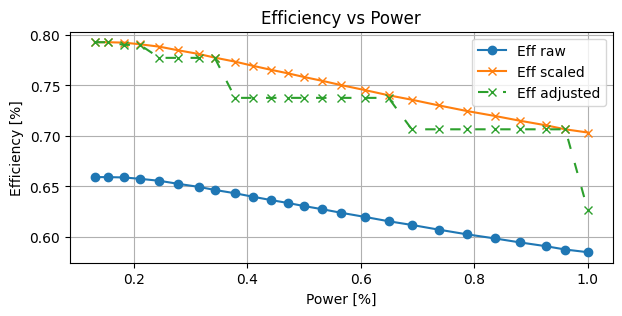

In [46]:
# Plot the data of the original efficiency curve and the adjusted ones
plt.figure(figsize=(7, 3))
plt.plot(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['Efficiency [%]'], label='Eff raw', marker='o')
plt.plot(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['Efficiency_scaled [%]'], label='Eff scaled', marker='x')
plt.plot(df_efficiency_adj['Power [%]'], df_efficiency_adj['eff_adjusted_electrolyzer'], label='Eff adjusted', marker='x', 
         linestyle='dashed', dashes=(5, 7))

plt.xlabel('Power [%]')
plt.ylabel('Efficiency [%]')
plt.title('Efficiency vs Power')
plt.legend()
plt.grid(True)
plt.show()

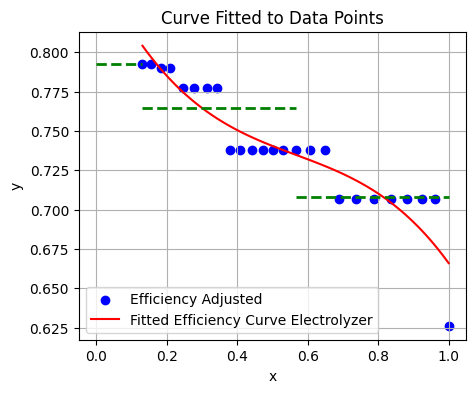

In [47]:
# Plotting the data points and the curve
plt.figure(figsize=(5, 4))
plt.scatter(df_efficiency_electrolyzer_adj['Power [%]'], df_efficiency_electrolyzer_adj['eff_adjusted_electrolyzer'], color='blue', label='Efficiency Adjusted')
plt.plot(x_values_electrolyzer, y_values_electrolyzer, color='red', label='Fitted Efficiency Curve Electrolyzer')

# Plotting segment averages
for i, (x_start, x_end) in enumerate(segment_x_values_electrolyzer):
    plt.plot([x_start, x_end], [segment_averages_electrolyzer[i], segment_averages_electrolyzer[i]], color='green', linestyle='--', linewidth=2)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Curve Fitted to Data Points')
plt.legend()
plt.grid(True)
plt.show()

#### Add operating points to user constraint

In [48]:
###Summarize all variable efficiencies
# Collect all data frames that start with variable_efficiency
dfs = [value for key, value in globals().items() if key.startswith('variable_efficiency') and isinstance(value, pd.DataFrame)]

# Choose the first column with the most segments
longest_df = max(dfs, key=lambda df: df.shape[0])
first_column = longest_df.iloc[:, 0]

# Concatenate the remaining columns from all DataFrames, ensuring no duplicate "first column"
remaining_columns = [df.iloc[:, 1:] for df in dfs]

# Concatenate the remaining columns to the longest first column
df_variable_efficiency = pd.concat([first_column] + remaining_columns, axis=1)
df_variable_efficiency

,relationship_class_name:,unit__from_node__user_constraint,unit__to_node__user_constraint
0,User_constraint_name,effcurve_electrolyzer,effcurve_electrolyzer
1,Object_name,electrolyzer,electrolyzer
2,Node_name,power,power
3,Parameter,unit_flow_coefficient,unit_flow_coefficient
4,0,0.792754,-1.0
5,1,0.764365,NaN
6,2,0.707758,NaN


In [49]:
# Relate all user_constraints to entity class name "user_constraint" 

Entity_names_duplicate = df_variable_efficiency.iloc[0,1:]
User_constraint_entities = []
for name in Entity_names_duplicate:
    if name not in User_constraint_entities:
        User_constraint_entities.append(name)
        

User_constraint_column = ["user_constraint"]*len(User_constraint_entities)

merged_columns = {"Entity class names": User_constraint_column, "Entity names": User_constraint_entities}
df_variable_eff_def= pd.DataFrame(merged_columns)
df_variable_eff_def

,Entity class names,Entity names
0,user_constraint,effcurve_electrolyzer


In [50]:
### Summarize all operating points
# Collect all data frames that start with operating_points
dfs = [value for key, value in globals().items() if key.startswith('operating_points') and isinstance(value, pd.DataFrame)]

# Choose the first column with the most segments
longest_df = max(dfs, key=lambda df: df.shape[0])
first_column = longest_df.iloc[:, 0]

# Concatenate the remaining columns from all DataFrames, ensuring no duplicate "first column"
remaining_columns = [df.iloc[:, 1:] for df in dfs]

# Concatenate the remaining columns to the longest first column
df_operating_points = pd.concat([first_column] + remaining_columns, axis=1)

In [51]:
### Summarize all ordered_unit_flow_op
# Collect all data frames that start with ordered_unit_flow_op
dfs = [value for key, value in globals().items() if key.startswith('ordered_unit_flow_') and isinstance(value, pd.DataFrame)]

# Concatenate the remaining columns to the longest first column
df_boolean_relations = pd.concat(dfs, ignore_index=True)

### Environment and Storages

#### Time Series:

In [52]:
# Adjust renewables columns names
df_PV_availabilityfactors_values.rename(columns={'time': 'time [UTC]', 
                                                 'local_time': 'time [' + area + ']',
                                                 'electricity': 'unit_availability_factor'}, inplace=True)
df_wind_availabilityfactors_values.rename(columns={'time': 'time [UTC]',
                                                   'local_time': 'time [' + area + ']',
                                                   'electricity_onshore': 'unit_availability_factor_onshore',
                                                   'electricity_offshore': 'unit_availability_factor_offshore'}, inplace=True)
# Adjust power prices
df_powerprices_values.rename(columns={'HourUTC': 'time [UTC]', 
                                         'HourDK': 'time [' + area + ']'}, inplace=True)

#### Renewables Availability:

In [53]:
# Create table headers and relations
column_names_1 = {'DateTime '+area: [None, None]}

# Add time values
df_temp_1 = pd.DataFrame(columns=['DateTime ' + area])
df_temp_1['DateTime '+area] = df_time

# Add solar values
if 'Solar plant' in powers:
    column_names_1['solar_plant'] = ['unit', 'unit_availability_factor']
    df_temp_1['solar_plant'] = df_PV_availabilityfactors_values['unit_availability_factor']
    
    # Fill NaNs on last day by copying previous day (only for leap years)
    df_temp_1['solar_plant_shifted'] = df_temp_1['solar_plant'].shift(24)
    df_temp_1['solar_plant'] = df_temp_1['solar_plant'].fillna(df_temp_1['solar_plant_shifted'])
    df_temp_1 = df_temp_1.drop(columns=['solar_plant_shifted'])

# Add onshore wind values
if 'Wind onshore' in powers:
    column_names_1['wind_onshore'] = ['unit', 'unit_availability_factor']
    df_temp_1['wind_onshore'] = df_wind_availabilityfactors_values['unit_availability_factor_onshore']
    
    # Fill NaNs on last day by copying previous day (only for leap years)
    df_temp_1['wind_onshore_shifted'] = df_temp_1['wind_onshore'].shift(24)
    df_temp_1['wind_onshore'] = df_temp_1['wind_onshore'].fillna(df_temp_1['wind_onshore_shifted'])
    df_temp_1 = df_temp_1.drop(columns=['wind_onshore_shifted'])

# Add offshore wind values
if 'Wind offshore' in powers:
    column_names_1['wind_offshore'] = ['unit', 'unit_availability_factor']
    df_temp_1['wind_offshore'] = df_wind_availabilityfactors_values['unit_availability_factor_offshore']
    
    # Fill NaNs on last day by copying previous day (only for leap years)
    df_temp_1['wind_offshore_shifted'] = df_temp_1['wind_offshore'].shift(24)
    df_temp_1['wind_offshore'] = df_temp_1['wind_offshore'].fillna(df_temp_1['wind_offshore_shifted'])
    df_temp_1 = df_temp_1.drop(columns=['wind_offshore_shifted'])


#Add chosen availability factors to one combined dataframe
df_blank_table_1 = pd.DataFrame(column_names_1, index=None)
df_time_series = pd.concat([df_blank_table_1, df_temp_1])

# Show table head for control
df_time_series.head()

,DateTime DK_1,solar_plant
0,None,unit
1,None,unit_availability_factor
0,2019-01-01T00:00:00,0.0
1,2019-01-01T01:00:00,0.0
2,2019-01-01T02:00:00,0.0


#### Energy prices:

In [54]:
# Adjustments of power price variance

# Calculate the current mean and variance
mean = df_powerprices_values[str(area)].mean()
current_variance = df_powerprices_values[str(area)].var()

# Define the new desired variance 
desired_variance = current_variance * power_price_variance

# Calculate the scaling factor
scaling_factor = np.sqrt(desired_variance / current_variance)

# Adjust the time series to achieve the new variance
df_powerprices_values[str(area)] = mean + (df_powerprices_values[str(area)] - mean) * scaling_factor

In [55]:
# Create table
column_names_2 = {'DateTime ' + area: ['relationship class','connection','node','parameter name'],
                'power_wholesale_in': ['connection__from_node','pl_wholesale','power_wholesale','connection_flow_cost'], 
                'power_wholesale_out': ['connection__to_node','pl_wholesale','power_wholesale','connection_flow_cost'], 
                'district_heating': ['connection__to_node','pl_dh','dh','connection_flow_cost']}
df_blank_table_2 = pd.DataFrame(column_names_2, index=None)

# Add values
df_temp_2 = pd.DataFrame(columns=['DateTime ' + area, 'power_wholesale_in', 'power_wholesale_out', 'district_heating'])

df_temp_2['DateTime ' + area] = df_time
df_temp_2['power_wholesale_in'] = price_level_power * df_powerprices_values[str(area)]
df_temp_2['power_wholesale_out'] = -1 * price_level_power * df_powerprices_values[str(area)]
df_temp_2['district_heating'] = -1 * df_district_heating_price[str(year)].loc[2] * share_of_dh_price_cap

df_table_2 = pd.concat([df_blank_table_2, df_temp_2], ignore_index=True)

# Remove wholesale 
if 'Grid' not in powers:
    df_table_2 = df_table_2.drop(columns=['power_wholesale_in', 'power_wholesale_out'])

In [56]:
# Add grid costs for consumption and production
if 'Grid' in powers:
    # Create table
    column_names_3 = {'grid_costs_consumption': ['connection__to_node', 'pl_wholesale', 'power', 'connection_flow_cost'],
                 'grid_costs_production': ['connection__from_node', 'pl_wholesale', 'power', 'connection_flow_cost']}
    df_blank_table_3 = pd.DataFrame(column_names_3, index=None)
    
    # Add values
    df_temp_3 = pd.DataFrame(columns=['Grid_costs_consumption', 'Grid_costs_production'])
    
    df_temp_3['grid_costs_consumption'] = df_grid_costs['consumption costs']
    df_temp_3['grid_costs_production'] = df_grid_costs['production costs']
    
    df_table_3 = pd.concat([df_blank_table_3, df_temp_3], ignore_index = True)
    
    # Merge all energy prices
    df_energy_prices = pd.concat([df_table_2, df_table_3], axis = 1)
else:
    df_energy_prices = df_table_2

# Show table head for control
df_energy_prices.head()

,DateTime DK_1,power_wholesale_in,power_wholesale_out,district_heating,grid_costs_consumption,grid_costs_production,Grid_costs_consumption,Grid_costs_production
0,relationship class,connection__from_node,connection__to_node,connection__to_node,connection__to_node,connection__from_node,NaN,NaN
1,connection,pl_wholesale,pl_wholesale,pl_dh,pl_wholesale,pl_wholesale,NaN,NaN
2,node,power_wholesale,power_wholesale,dh,power,power,NaN,NaN
3,parameter name,connection_flow_cost,connection_flow_cost,connection_flow_cost,connection_flow_cost,connection_flow_cost,NaN,NaN
4,2019-01-01T00:00:00,28.32,-28.32,-18.579088,11.702413,0,NaN,NaN


#### Units on costs:

In [57]:
# Add units on costs for all units that have either min_down_time, ramp_up/down_limits, or start_up/shut_down limits/costs
# Filter units_parameter_df and df_object__node
cost_parameters = ['min_down_time', 'min_up_time', 'shut_down_cost', 'start_up_cost', 
                   'ramp_down_limit', 'ramp_up_limit', 'start_up_limit', 'shut_down_limit']
filtered_units_parameter_df = unit_parameters_df[unit_parameters_df['Parameter'].isin(cost_parameters)]
filtered_df_object__node = df_object__node[df_object__node['Parameter'].isin(cost_parameters)]

combined_object_names = pd.concat([filtered_units_parameter_df['Object_name'], filtered_df_object__node['Object_name']])
unique_objects = combined_object_names.unique()

# Check if they already have a units_on_cost value other than 0
non_zero_units_df = unit_parameters_df[(unit_parameters_df['Parameter'] == 'units_on_cost') & 
                                       (unit_parameters_df['Value'] != 0.0)]
non_zero_units = non_zero_units_df['Object_name'].unique()

# Remove units_on_cost = 0 from unit_parameters_df if in unique_objects
unit_parameters_df = unit_parameters_df[~(
    (unit_parameters_df['Parameter'] == 'units_on_cost') & 
    (unit_parameters_df['Value'] == 0) & 
    (unit_parameters_df['Object_name'].isin(unique_objects))
)]

unique_units = [unit for unit in unique_objects if unit not in non_zero_units]

# Create new columns for each unique unit in df_time_series
for unit in unique_units:
    unit_data = ["unit", "units_on_cost"]
    
    power_data = df_temp_2['power_wholesale_in'].tolist()
    
    #df_time_series[unit] = unit_data + power_data
    # Reset the index of df_time_series to avoid non-unique index error
    df_time_series = df_time_series.reset_index(drop=True)
    # Create a temporary DataFrame for the new column
    new_column = pd.DataFrame({unit: unit_data + power_data})
    # Ensure the new column has the same length as df_time_series
    new_column = new_column.reindex(df_time_series.index)
    # Use pd.concat to add new columns without overwriting existing ones
    df_time_series = pd.concat([df_time_series, new_column], axis=1)


# Show table head for control
df_time_series.head()

,DateTime DK_1,solar_plant,ch3oh_reactor
0,None,unit,unit
1,None,unit_availability_factor,units_on_cost
2,2019-01-01T00:00:00,0.0,28.32
3,2019-01-01T01:00:00,0.0,10.07
4,2019-01-01T02:00:00,0.0,-4.08


#### Time Series Storage:

In [58]:
# Date index
start_date = pd.to_datetime(start_date)
before = start_date-timedelta(hours=1)
formatted_before = before.strftime('%Y-%m-%dT%H:%M:%S')

df_beginning = pd.DataFrame({'DateTime': [np.nan, formatted_before]})

df_temp4 = pd.DataFrame(columns=['DateTime'])
df_temp4 = pd.concat([df_beginning, df_time], ignore_index = True)

# Get storage values for fix_node_state
storage_values = df_model_storages.iloc[:,[0, 2, 6]]
storage_values = storage_values.iloc[:, [0, 2, 1]]
storage_values_transposed = storage_values.T
storage_values_transposed.columns = storage_values_transposed.iloc[0]
storage_values_transposed = storage_values_transposed[1:]
storage_values_transposed.reset_index(drop=True, inplace=True)

df_storage = pd.concat([df_temp4, storage_values_transposed], axis=1)

In [59]:
# Add storage if roll_forward and a min_shut_down_period are used
product_tr = translate_product(product)
last_storage = f"{product_tr}_st"
indices = list(range(1, num_slices))

if "min_down_time" in unit_parameters_duration_df['Parameter'].values and roll_forward_use:
    new_column = pd.DataFrame({last_storage: ['node_state_min']})
    # Add to the rest of the storage df
    df_storage = pd.concat([df_storage, new_column], axis=1)
    
    # Down time
    min_down_df = unit_parameters_duration_df[unit_parameters_duration_df['Parameter'].isin({'min_down_time'})]
    min_down_df['Value'] = min_down_df['Value'].str[:-1].astype(float)
    time_down = max(min_down_df['Value'])
    
    # Demand hourly
    demand = df_nodes.loc[df_nodes['Object_name'] == f"{product_tr}_demand", 'demand'].values
    demand = demand[0]
    
    storage_needed = demand * time_down
    
    # Add storage_needed at relevant indices and set the next cell to 0
    for i in indices:
        index_value = (i * roll_forward_size) + 1 #plus one as it starts in the last hour of the prior period
        df_storage.iloc[index_value, -1] = storage_needed
        
        # Set the cell after storage_needed to 0 if it exists within bounds
        next_index = index_value + 1
        if next_index < len(df_storage):
            df_storage.iloc[next_index, -1] = 0
    
# Show table head for control
df_storage.head()

,DateTime,h2_st,ch3oh_st,power_st
0,NaN,fix_node_state,fix_node_state,fix_node_state
1,2018-12-31T23:00:00,0,0,0
2,2019-01-01T00:00:00,NaN,NaN,NaN
3,2019-01-01T01:00:00,NaN,NaN,NaN
4,2019-01-01T02:00:00,NaN,NaN,NaN


## Creating one combined excel and export

In [60]:
# Create the prepared input excel for the use in SpineToolbox
with pd.ExcelWriter(output_file_path + output_file_name) as writer:
    df_definition.to_excel(writer, sheet_name='Definition', index=False)
    unit_parameters_rest_df.to_excel(writer, sheet_name='Definition_parameters', index=False)
    unit_parameters_duration_df.to_excel(writer, sheet_name='Definition_parameters_duration', index=False)
    df_units_inv_parameters.to_excel(writer, sheet_name='Unit_Inv_Parameters', index=False)
    df_nodes.to_excel(writer, sheet_name='Nodes', index=False)
    df_connections_inv_parameters.to_excel(writer, sheet_name='Connection_Inv_Parameters', index=False)
    df_storages_inv_parameters.to_excel(writer, sheet_name='Storage_Inv_Parameters', index=False)
    df_object__node_definitions.to_excel(writer, sheet_name='Object__to_from_node_definition', index=False)
    df_object__node_values.to_excel(writer, sheet_name='Object__to_from_node', index=False)
    df_boolean_relations.to_excel(writer, sheet_name='Boolean_relations', index=False)
    df_object_node_node.to_excel(writer, sheet_name='Object__node_node', index=False)
    df_variable_eff_def.to_excel(writer, sheet_name='Variable_Eff_Definition', index=False)
    df_variable_efficiency.to_excel(writer, sheet_name='Variable_Eff', index=False)
    df_operating_points.to_excel(writer, sheet_name='Operating_points', index=False)
    df_storage.to_excel(writer, sheet_name='Time_series_storage', index=False)
    df_time_series.to_excel(writer, sheet_name='Time_series', index=False)
    df_energy_prices.to_excel(writer, sheet_name='Energy_prices', index=False)
    df_model_components.to_excel(writer, sheet_name='Model_components', index=False)
    df_model_relations.to_excel(writer, sheet_name='Model_relations', index=False)
    df_model.to_excel(writer, sheet_name='Model', index=False)
    df_temporal_relations.to_excel(writer, sheet_name='Temporal_relations', index=False)